In [6]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np

from dotenv import load_dotenv
load_dotenv("../.env")
DATASET_PATH=os.getenv("DATASET_DIRECTORY")
MODEL_TRAINING_DATASET_PATH=os.getenv("MODEL_TRAINING_DATASET_PATH")
GENERATED_DATASETS_PATH=os.getenv("GENERATED_DATASETS_PATH")


sys.path.append("../")
from cpsl_datasets.gnn_node_ds import GnnNodeDS

from mmwave_model_integrator.input_encoders._node_encoder import _NodeEncoder
from mmwave_model_integrator.ground_truth_encoders._gt_node_encoder import _GTNodeEncoder
from mmwave_model_integrator.plotting.plotter_gnn_pc_processing import PlotterGnnPCProcessing
from mmwave_model_integrator.model_runner.gnn_runner import GNNRunner
from mmwave_model_integrator.torch_training.models.SAGEGnn import SageGNNClassifier


In [7]:
#initialize the dataset
dataset_path = os.path.join(DATASET_PATH,"gnn_train")
dataset = GnnNodeDS(
    dataset_path=dataset_path,
    node_folder="nodes",
    label_folder="labels"
)
print(dataset_path)

found 393 node samples
found 393 label samples
/data/radnav/radnav_model_train_datasets/gnn_train


In [8]:
#initialize the encoder and decoder
input_encoder = _NodeEncoder()
ground_truth_encoder = _GTNodeEncoder()
plotter = PlotterGnnPCProcessing()

#testing the output

runner = GNNRunner(
    model= SageGNNClassifier(
        in_channels=4,
        hidden_channels=16,
        out_channels=1
    ),state_dict_path="/home/david/Documents/odometry/submodules/mmwave_model_integrator/notebooks/working_dir/Sage_GNN.pth",
    cuda_device="cpu",
    edge_radius=5.0
)

_ModelRunner: using CPU


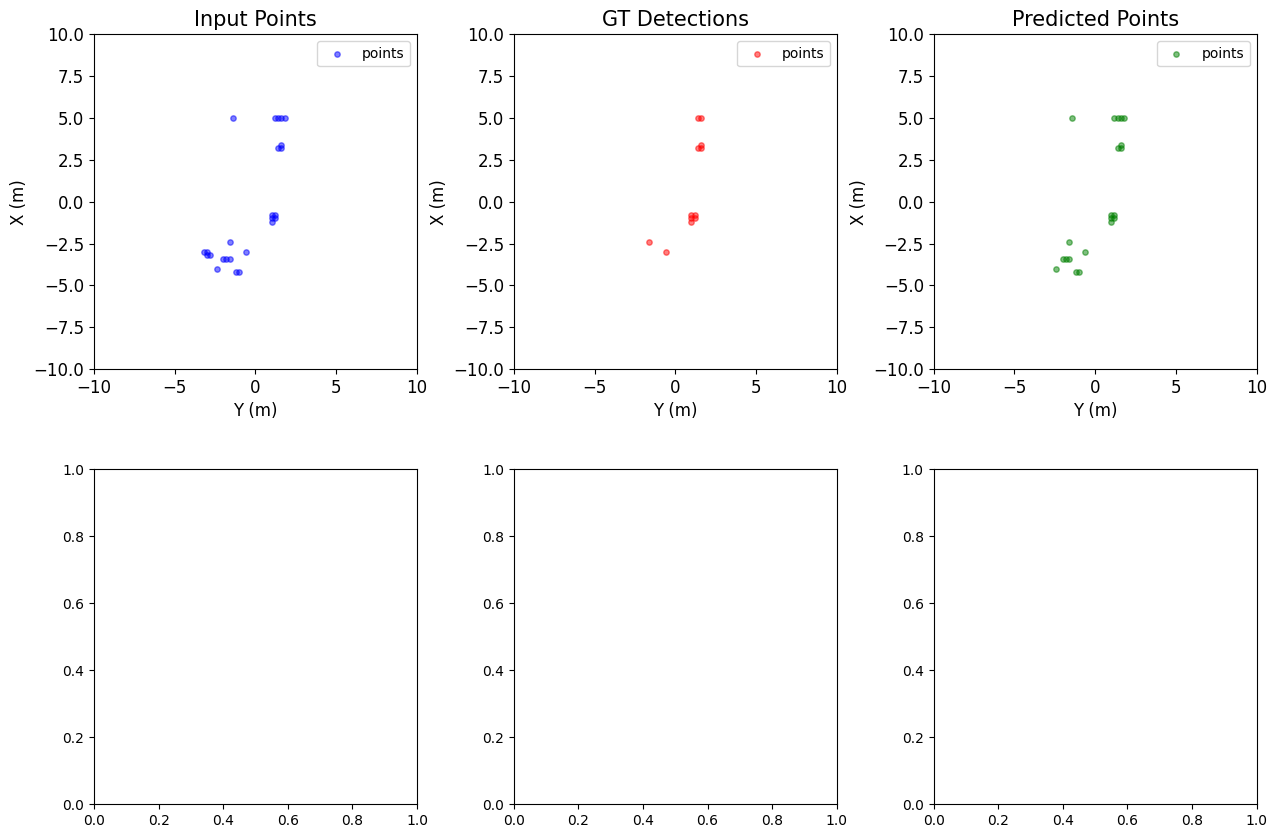

In [9]:
#plot a sample from the training dataset
nodes = dataset.get_node_data(idx=1)
labels = dataset.get_label_data(idx=1)
plotter.plot_compilation(
    nodes=nodes,
    labels=labels,
    input_encoder=input_encoder,
    ground_truth_encoder=ground_truth_encoder,
    runner=runner,
    show=True
)

In [11]:
#quick speed comparison
from tqdm import tqdm

for i in tqdm(range(dataset.num_frames)):

    nodes = dataset.get_node_data(idx=i)
    labels = dataset.get_label_data(idx=i)

    pred = runner.make_prediction(nodes)

100%|██████████| 393/393 [00:00<00:00, 1348.60it/s]
